# ML Expermients

Now that we have the data process we will run some experments using ml 

# Import Rquired Libraries

In [62]:
import pandas as pd
import numpy as np
import joblib
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,root_mean_squared_log_error
import xgboost as xgb
import yaml
import os
import logging
from contextlib import nullcontext
import matplotlib.pyplot as plt




In [6]:
from pathlib import Path
pd.set_option('display.max_columns',None)

In [7]:
from sklearn.preprocessing import RobustScaler

In [35]:
import lightgbm as lgb

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# Setup mlflow

In [2]:
mlflow_tracking_uri = 'http://localhost:5000' 

In [3]:
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [4]:
exp_id = mlflow.create_experiment(name='HousePricePredictions')

In [5]:
exp_id

'6'

# Load Data

In [8]:
data_loc = Path('/home/ExraDrive/house_prices/processed')

In [45]:
df = pd.read_pickle(data_loc /'house_price_processed.pkl')

In [46]:
df.isnull().sum()

OverallQual             0
OverallCond             0
age_at_sale             0
age_of_house_squared    0
house_have_remodel      0
GrLivArea               0
TotalBsmtSF             0
total_sf                0
ratio_finished_bsmt     0
basement_ratio          0
total_full_baths        0
total_half_baths        0
BedroomAbvGr            0
bedrooms_per_1ksf       0
bed_bath_ratio          0
has_garage              0
garage_finished         0
SalePrice               0
dtype: int64

# Split data for training

In [47]:
X = df.drop('SalePrice',axis=1)
y = df['SalePrice']

In [48]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=23)

## Preprocess binary features

covert yes or no features to 1 or 0

In [49]:
df.head()

,OverallQual,OverallCond,age_at_sale,age_of_house_squared,house_have_remodel,GrLivArea,TotalBsmtSF,total_sf,ratio_finished_bsmt,basement_ratio,total_full_baths,total_half_baths,BedroomAbvGr,bedrooms_per_1ksf,bed_bath_ratio,has_garage,garage_finished,SalePrice
0,7,5,5,25,no,1710,856,2566,0.823804,0.333463,3,1,3,0.841279,1.000000,yes,yes,208500
1,6,8,31,961,no,1262,1262,2524,0.774347,0.499802,2,1,3,0.851305,1.500000,yes,yes,181500
2,7,5,7,49,yes,1786,920,2706,0.527687,0.339860,3,1,3,0.809498,1.000000,yes,yes,223500
3,7,5,91,8281,yes,1717,756,2473,0.285337,0.305578,2,0,3,0.863807,1.500000,yes,no,140000
4,8,5,8,64,no,2198,1145,3343,0.571553,0.342404,3,1,4,0.921022,1.333333,yes,yes,250000


In [50]:
binay_feats = ['house_have_remodel','has_garage','garage_finished']

In [51]:
for feat in binay_feats:
    x_train[feat]=np.where(x_train[feat].isin(['yes','Yes','Y','y']),1,0)
    x_test[feat]=np.where(x_test[feat].isin(['yes','Yes','Y','y']),1,0)

In [52]:
x_train.isnull().sum()

OverallQual             0
OverallCond             0
age_at_sale             0
age_of_house_squared    0
house_have_remodel      0
GrLivArea               0
TotalBsmtSF             0
total_sf                0
ratio_finished_bsmt     0
basement_ratio          0
total_full_baths        0
total_half_baths        0
BedroomAbvGr            0
bedrooms_per_1ksf       0
bed_bath_ratio          0
has_garage              0
garage_finished         0
dtype: int64

# Find the Most important Features

In [17]:
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor



In [26]:
xgb_model = XGBRegressor(objective='reg:squaredlogerror')

In [27]:
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:squaredlogerror', ...)

In [29]:
x_train.shape

(1168, 17)






print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]


# Defind Models and hyperparameter

Here we will define the models we will test and its hyperperamters to search

In [74]:
# Define models and hyperparameter grids
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror'),
    'LightGBM':lgb.LGBMRegressor()
}

model_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20]
    },
    'GradientBoosting': {
        'n_estimators': [100, 250],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'learning_rate': [0.1, 0.05],
        'max_depth': [3, 10]
    },
    'LightGBM':{
        'n_estimators':[100,150],
        'learning_rate':[0.1,0.05],
        'num_leaves':[25,35]
    }
}


In [54]:
x_train.head()

,OverallQual,OverallCond,age_at_sale,age_of_house_squared,house_have_remodel,GrLivArea,TotalBsmtSF,total_sf,ratio_finished_bsmt,basement_ratio,total_full_baths,total_half_baths,BedroomAbvGr,bedrooms_per_1ksf,bed_bath_ratio,has_garage,garage_finished
1290,5,7,46,2116,0,1152,1152,2304,0.879445,0.499783,2,0,3,0.907990,1.5,1,1
793,8,5,0,0,0,1496,1496,2992,0.000000,0.499833,2,0,3,0.751503,1.5,1,1
83,5,5,47,2209,0,1065,1065,2130,0.000000,0.499765,1,1,3,0.958466,3.0,1,0
432,5,5,36,1296,0,1365,765,2130,0.614883,0.358986,2,1,2,0.638978,1.0,1,0
929,7,5,9,81,0,2236,964,3200,0.000000,0.301156,2,1,4,0.952381,2.0,1,1


In [64]:
y_train

1290    180500
793     225000
83      126500
432     122500
929     222000
         ...  
31      149350
950     129000
1064    154000
742     179000
595     319000
Name: SalePrice, Length: 1168, dtype: int64

In [75]:
def evaluate_model_with_gridsearch(name, model, grid, x_train, y_train, x_test, y_test):
    X_train=x_train.copy()
    X_test=x_test.copy()
    if grid:
        clf = GridSearchCV(model, grid, cv=3, scoring='r2', n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        if name=='LinearRegression':
            # need to transform numeric feets
            feats=['GrLivArea','TotalBsmtSF','total_sf']
            for feat in feats:
                X_train[feat]=X_train[feat].apply(lambda x: np.log1p(x))
                X_test[feat]=X_test[feat].apply(lambda x: np.log1p(x))
            print(X_train[feats].isnull().sum())
            r_scaler = RobustScaler()
            X_train[feats]=r_scaler.fit_transform(X_train[feats])
            X_test[feats]=r_scaler.transform(X_test[feats])
            print(f'after transform: {X_train[feats].isnull().sum()}')
            print(f'after transform test: {X_test[feats].isnull().sum()}')
        model.fit(X_train, y_train)
        best_model = model
        best_params = model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model,
        'params': best_params
    }

print("MLflow tracking URI:", mlflow_tracking_uri)


MLflow tracking URI: http://localhost:5000


# Run model experiments

In [76]:
results = {}

with mlflow.start_run(experiment_id=exp_id,run_name="model_comparisons") as parent_run:
    print(f'we are in the {parent_run.info.artifact_uri}')
    print(f'expermrent info: {parent_run.info.experiment_id}')
    for name, model in models.items():
        with mlflow.start_run(experiment_id=exp_id,run_name=name, nested=True) as child_runs:
            print(f'weare now testing: {child_runs.info.run_name}')
            print(f'its info is: {child_runs.info.experiment_id}')
            evaluation = evaluate_model_with_gridsearch(name, model, model_grids[name], x_train, y_train, x_test, y_test)
            results[name] = evaluation

            if mlflow_tracking_uri:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({
                    'mae': evaluation['mae'],
                    'mse': evaluation['mse'],
                    'rmse': evaluation['rmse'],
                    'r2': evaluation['r2']
                })
                mlflow.sklearn.log_model(evaluation['model'], artifact_path=name.lower().replace(" ", "_"))
            
            print(f"{name} R2: {evaluation['r2']:.4f}, RMSE: {evaluation['rmse']:.2f}")


we are in the file:///home/ExraDrive/mlflow/mlruns/6/bd8bd27c93a64f79a43f0c913c6ab8c5/artifacts
expermrent info: 6
weare now testing: LinearRegression
its info is: 6
GrLivArea      0
TotalBsmtSF    0
total_sf       0
dtype: int64
after transform: GrLivArea      0
TotalBsmtSF    0
total_sf       0
dtype: int64
after transform test: GrLivArea      0
TotalBsmtSF    0
total_sf       0
dtype: int64


2025/11/11 13:14:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LinearRegression R2: 0.8231, RMSE: 29863.59
🏃 View run LinearRegression at: http://localhost:5000/#/experiments/6/runs/1fcb29c2aa73499cb497cc4c6a130dd5
🧪 View experiment at: http://localhost:5000/#/experiments/6
weare now testing: RandomForest
its info is: 6


2025/11/11 13:14:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest R2: 0.8705, RMSE: 25551.91
🏃 View run RandomForest at: http://localhost:5000/#/experiments/6/runs/6b27ab97a1a94dbdab678cd4ca7e2944
🧪 View experiment at: http://localhost:5000/#/experiments/6
weare now testing: GradientBoosting
its info is: 6


2025/11/11 13:14:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GradientBoosting R2: 0.8801, RMSE: 24586.64
🏃 View run GradientBoosting at: http://localhost:5000/#/experiments/6/runs/87b3902576064469a81e3ee0ea901b42
🧪 View experiment at: http://localhost:5000/#/experiments/6
weare now testing: XGBoost
its info is: 6


2025/11/11 13:14:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost R2: 0.8914, RMSE: 23402.42
🏃 View run XGBoost at: http://localhost:5000/#/experiments/6/runs/4d8e01e2a6544a67837c1566a9c087e3
🧪 View experiment at: http://localhost:5000/#/experiments/6
weare now testing: LightGBM
its info is: 6
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1688
[LightGBM] [Info] Number of data points in the train set: 778, number of used features: 17
[LightGBM] [Info] Start training from score 178234.030848
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 779, number of used features: 17
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

2025/11/11 13:24:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM R2: 0.8930, RMSE: 23228.97
🏃 View run LightGBM at: http://localhost:5000/#/experiments/6/runs/30341c5084e94222b968801ef13e501a
🧪 View experiment at: http://localhost:5000/#/experiments/6
🏃 View run model_comparisons at: http://localhost:5000/#/experiments/6/runs/bd8bd27c93a64f79a43f0c913c6ab8c5
🧪 View experiment at: http://localhost:5000/#/experiments/6


# visualize results

In [77]:
def plot_model_metrics(results, metric='r2'):
    names = list(results.keys())
    values = [results[name][metric] for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, values)
    plt.title(f'Model Comparison by {metric.upper()}')
    plt.xlabel('Model')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.show()





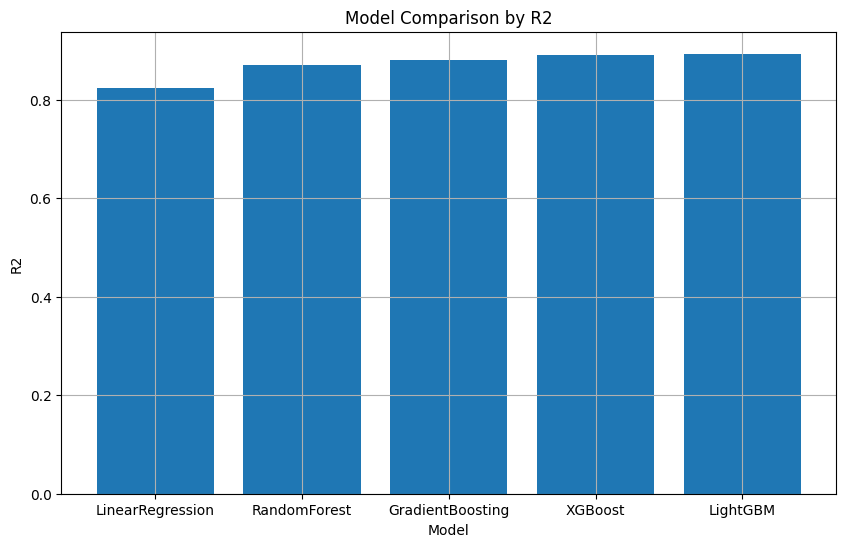

In [78]:
# Example usage:
plot_model_metrics(results, metric='r2')



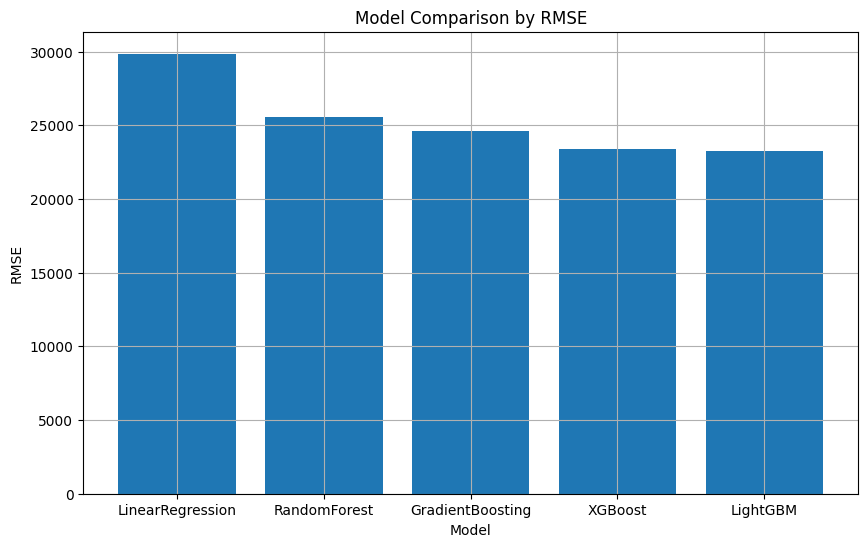

In [79]:
plot_model_metrics(results, metric='rmse')

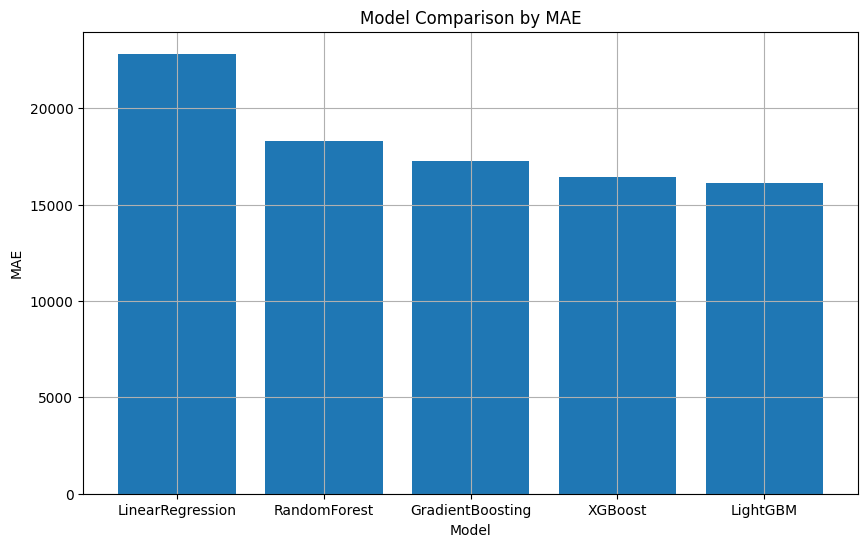

In [80]:
plot_model_metrics(results, metric='mae')

In [81]:

# Display information about the best model
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
best_params = best_model.get_params()
best_r2 = float(results[best_model_name]['r2'])
best_mae = float(results[best_model_name]['mae'])
best_rmse = float(results[best_model_name]['rmse'])

print(f"🏆 Best Model: {best_model_name}")
print(f"   R² Score: {best_r2:.4f}")
print(f"   MAE: {best_mae:.2f}")
print(f"   RMSE: {best_rmse:.2f}")
print(f'Best models params: {best_params}')




🏆 Best Model: LightGBM
   R² Score: 0.8930
   MAE: 16136.43
   RMSE: 23228.97
Best models params: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 35, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


model_config = {
    'model': {
        'name': 'house_price_model',
        'best_model': best_model_name,
        'parameters': best_params,
        'r2_score': best_r2,
        'mae': best_mae,
        'target_variable': 'price',
        'feature_sets': selected_features_dict
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f)

print(f"Saved model config to {config_path}")